In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import required libraries

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import sklearn
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

encoder = preprocessing.LabelEncoder()

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Covid-19-Patient-Health-Analytics-master/Covid-19-Patient-Health-Analytics-master/cvd/data.csv')

Data Set Descriptions

This dataset provides information on COVID-19 patients, including demographic details, travel history, health status, and reported symptoms. The primary objective is to use these features to predict patient outcomes, specifically recovery or death.

 Description of Features


Location & Country: Indicate the geographic area of the patient, useful for analyzing regional trends in COVID-19 severity and outcomes.  
Age & Gender: Demographic features critical for understanding age- and gender-related risks associated with COVID-19.   
Symptom Onset & Hospital Visit Dates: These date features allow calculation of the delay between symptom onset and hospitalization, potentially highlighting response times.  
Visit to Wuhan: A binary feature indicating if the patient had recent travel history to Wuhan, useful for early COVID-19 tracking.  
Death & Recovery Status: Target variables representing the outcomes of COVID-19 cases, indicating if a patient recovered or succumbed to the virus.



Dataset Challenges

Missing Values: Certain columns contain missing data, which requires handling during preprocessing.  
Imbalanced Classes: The dataset may have a higher number of recoveries than deaths, which can impact the model's accuracy in predicting the minority class (deaths).


In [4]:
data.head(10)

,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,recov,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6
0,1,"Shenzhen, Guangdong",China,male,66.0,1/3/2020,1/11/2020,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Shanghai,China,female,56.0,1/15/2020,1/15/2020,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Zhejiang,China,male,46.0,1/4/2020,1/17/2020,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Tianjin,China,female,60.0,NaN,NaN,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Tianjin,China,male,58.0,NaN,NaN,0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,6,Chongqing,China,female,44.0,NaN,NaN,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,7,Sichuan,China,male,34.0,NaN,NaN,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Beijing,China,male,37.0,1/14/2020,1/20/2020,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,9,Beijing,China,male,39.0,1/9/2020,1/14/2020,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,10,Beijing,China,male,56.0,1/16/2020,1/20/2020,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.describe()

,id,age,vis_wuhan,from_wuhan,death,recov
count,1085.000000,843.000000,1085.000000,1081.000000,1085.000000,1085.000000
mean,543.000000,49.483689,0.176959,0.144311,0.058065,0.146544
std,313.356825,18.255334,0.381810,0.351567,0.233973,0.353814
min,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000
25%,272.000000,35.000000,0.000000,0.000000,0.000000,0.000000
50%,543.000000,51.000000,0.000000,0.000000,0.000000,0.000000
75%,814.000000,64.000000,0.000000,0.000000,0.000000,0.000000
max,1085.000000,96.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1085 non-null   int64  
 1   location    1085 non-null   object 
 2   country     1085 non-null   object 
 3   gender      902 non-null    object 
 4   age         843 non-null    float64
 5   sym_on      449 non-null    object 
 6   hosp_vis    449 non-null    object 
 7   vis_wuhan   1085 non-null   int64  
 8   from_wuhan  1081 non-null   float64
 9   death       1085 non-null   int64  
 10  recov       1085 non-null   int64  
 11  symptom1    270 non-null    object 
 12  symptom2    161 non-null    object 
 13  symptom3    73 non-null     object 
 14  symptom4    19 non-null     object 
 15  symptom5    3 non-null      object 
 16  symptom6    1 non-null      object 
dtypes: float64(2), int64(4), object(11)
memory usage: 144.2+ KB


Data Analysis

checking for missing values

In [7]:

missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 id               0
location         0
country          0
gender         183
age            242
sym_on         636
hosp_vis       636
vis_wuhan        0
from_wuhan       4
death            0
recov            0
symptom1       815
symptom2       924
symptom3      1012
symptom4      1066
symptom5      1082
symptom6      1084
dtype: int64


In [8]:
# Analyzing unique values and their counts for categorical columns
categorical_cols = ['location', 'country', 'gender', 'vis_wuhan', 'from_wuhan']
for col in categorical_cols:
    print(f"\n{col} unique values and counts:\n{data[col].value_counts()}")



location unique values and counts:
location
South Korea          112
Singapore             93
Hong Kong             80
Hokkaido              48
Thailand              41
                    ... 
Arizona                1
Kathmandu              1
Langkawi               1
Nagano Prefecture      1
Bern                   1
Name: count, Length: 156, dtype: int64

country unique values and counts:
country
China          197
Japan          190
South Korea    114
Hong Kong       94
Singapore       93
Germany         54
Thailand        41
France          39
Taiwan          34
Spain           34
Malaysia        23
UAE             21
UK              20
Iran            18
USA             18
Bahrain         17
Vietnam         16
Australia       15
Canada          12
Kuwait           9
Italy            3
India            3
Phillipines      3
Austria          2
Russia           2
Sweden           1
Belgium          1
Egypt            1
Finland          1
Israel           1
Lebanon          1
Sri Lanka

In [9]:
#drop Id column
data = data.drop('id', axis=1)


In [10]:
#fill the null values
data = data.fillna(np.nan, axis=0)


In [11]:
data.head()

,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,recov,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6
0,"Shenzhen, Guangdong",China,male,66.0,1/3/2020,1/11/2020,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Shanghai,China,female,56.0,1/15/2020,1/15/2020,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,Zhejiang,China,male,46.0,1/4/2020,1/17/2020,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,Tianjin,China,female,60.0,NaN,NaN,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Tianjin,China,male,58.0,NaN,NaN,0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data.isnull().sum()

,0
location,0
country,0
gender,183
age,242
sym_on,636
hosp_vis,636
vis_wuhan,0
from_wuhan,4
death,0
recov,0


In [13]:

# Apply encoding to categorical features
data['location'] = encoder.fit_transform(data['location'].astype(str))
data['country'] = encoder.fit_transform(data['country'].astype(str))
data['gender'] = encoder.fit_transform(data['gender'].astype(str))
data['symptom1'] = encoder.fit_transform(data['symptom1'].astype(str))
data['symptom2'] = encoder.fit_transform(data['symptom2'].astype(str))
data['symptom3'] = encoder.fit_transform(data['symptom3'].astype(str))
data['symptom4'] = encoder.fit_transform(data['symptom4'].astype(str))
data['symptom5'] = encoder.fit_transform(data['symptom5'].astype(str))
data['symptom6'] = encoder.fit_transform(data['symptom6'].astype(str))


In [14]:
data.head()

,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,recov,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6
0,116,8,1,66.0,1/3/2020,1/11/2020,1,0.0,0,0,17,31,23,12,3,1
1,113,8,0,56.0,1/15/2020,1/15/2020,0,1.0,0,0,17,31,23,12,3,1
2,154,8,1,46.0,1/4/2020,1/17/2020,0,1.0,0,0,17,31,23,12,3,1
3,129,8,0,60.0,NaN,NaN,1,0.0,0,0,17,31,23,12,3,1
4,129,8,1,58.0,NaN,NaN,0,0.0,0,0,17,31,23,12,3,1


In [15]:
import datetime as dt

# Convert dates to datetime, coercing errors to NaT for invalid formats
data['sym_on'] = pd.to_datetime(data['sym_on'], errors='coerce')
data['hosp_vis'] = pd.to_datetime(data['hosp_vis'], errors='coerce')

# Handle NaT values (e.g., filling with a default date or dropping)
# Here, we fill NaT with a common date, such as the dataset's earliest date
# Adjust this as per your data needs, or use data.dropna(subset=['sym_on', 'hosp_vis'])
data['sym_on'].fillna(data['sym_on'].min(), inplace=True)
data['hosp_vis'].fillna(data['hosp_vis'].min(), inplace=True)

# Convert to ordinal date format
data['sym_on'] = data['sym_on'].map(dt.datetime.toordinal)
data['hosp_vis'] = data['hosp_vis'].map(dt.datetime.toordinal)

# Calculate difference in days between symptom onset and hospital visit
data['diff_sym_hos'] = data['hosp_vis'] - data['sym_on']

# Preview the result
print(data[['sym_on', 'hosp_vis', 'diff_sym_hos']].head())


   sym_on  hosp_vis  diff_sym_hos
0  737427    737435             8
1  737439    737439             0
2  737428    737441            13
3  737413    737420             7
4  737413    737420             7


<ipython-input-15-838aae0cd787>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sym_on'].fillna(data['sym_on'].min(), inplace=True)
<ipython-input-15-838aae0cd787>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [16]:
data.head()

,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,recov,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos
0,116,8,1,66.0,737427,737435,1,0.0,0,0,17,31,23,12,3,1,8
1,113,8,0,56.0,737439,737439,0,1.0,0,0,17,31,23,12,3,1,0
2,154,8,1,46.0,737428,737441,0,1.0,0,0,17,31,23,12,3,1,13
3,129,8,0,60.0,737413,737420,1,0.0,0,0,17,31,23,12,3,1,7
4,129,8,1,58.0,737413,737420,0,0.0,0,0,17,31,23,12,3,1,7


In [17]:
data.dtypes

,0
location,int64
country,int64
gender,int64
age,float64
sym_on,int64
hosp_vis,int64
vis_wuhan,int64
from_wuhan,float64
death,int64
recov,int64


now all datas in numerical types

Correlation Matrix

              location   country    gender       age    sym_on  hosp_vis  \
location      1.000000  0.281899  0.000653  0.005356 -0.129401 -0.133787   
country       0.281899  1.000000  0.140118 -0.046154 -0.084988 -0.086661   
gender        0.000653  0.140118  1.000000 -0.033799 -0.216677 -0.216553   
age           0.005356 -0.046154 -0.033799  1.000000  0.126001  0.133376   
sym_on       -0.129401 -0.084988 -0.216677  0.126001  1.000000  0.993618   
hosp_vis     -0.133787 -0.086661 -0.216553  0.133376  0.993618  1.000000   
vis_wuhan     0.024117 -0.102454  0.007664 -0.186654 -0.051217 -0.061639   
from_wuhan    0.159897 -0.219383 -0.134099  0.066846 -0.039833 -0.046714   
death         0.160176 -0.165504  0.014426  0.284602 -0.029000 -0.022163   
recov         0.137583  0.260023 -0.115152 -0.181658  0.052291  0.044090   
symptom1      0.067779 -0.059876  0.137400 -0.177505 -0.421539 -0.417432   
symptom2      0.047345 -0.035251  0.113751 -0.103409 -0.339563 -0.333849   
symptom3    

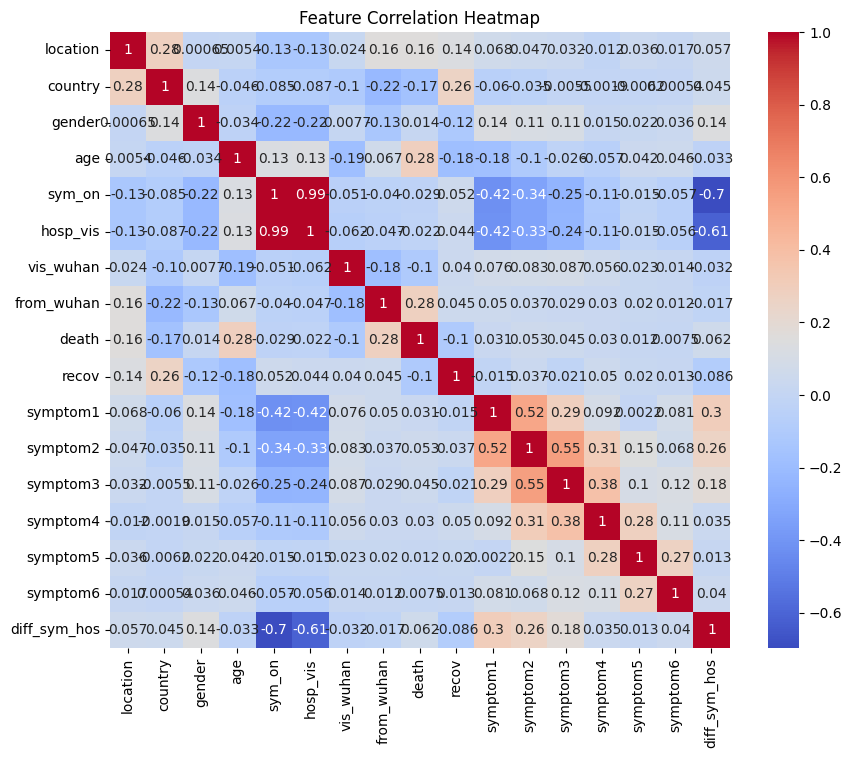

In [18]:
# Correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

# Visualize correlation with a heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [19]:
data.isnull().sum()

,0
location,0
country,0
gender,0
age,242
sym_on,0
hosp_vis,0
vis_wuhan,0
from_wuhan,4
death,0
recov,0


In [20]:
data['age'].fillna(data['age'].mean(), inplace=True)


<ipython-input-20-e2627324ccf1>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].mean(), inplace=True)


In [21]:
data.isnull().sum()

,0
location,0
country,0
gender,0
age,0
sym_on,0
hosp_vis,0
vis_wuhan,0
from_wuhan,4
death,0
recov,0


In [22]:
data = data.dropna(subset=['from_wuhan'])

In [23]:
data.isnull().sum()

,0
location,0
country,0
gender,0
age,0
sym_on,0
hosp_vis,0
vis_wuhan,0
from_wuhan,0
death,0
recov,0


Now there is no null values now data set is ready for training process

In [24]:

X = data.drop('death', axis=1)
y = data['death']



In [25]:
X.head()

,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,recov,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos
0,116,8,1,66.0,737427,737435,1,0.0,0,17,31,23,12,3,1,8
1,113,8,0,56.0,737439,737439,0,1.0,0,17,31,23,12,3,1,0
2,154,8,1,46.0,737428,737441,0,1.0,0,17,31,23,12,3,1,13
3,129,8,0,60.0,737413,737420,1,0.0,0,17,31,23,12,3,1,7
4,129,8,1,58.0,737413,737420,0,0.0,0,17,31,23,12,3,1,7


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import numpy as np

# Initialize the RandomForestClassifier with necessary parameters
rf = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_depth=2,
    max_features='sqrt',  # Use 'sqrt' instead of 'auto'
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=2,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_jobs=None,
    oob_score=False,
    random_state=None,
    verbose=0,
    warm_start=False
)

# Initialize the AdaBoostClassifier with RandomForestClassifier as the estimator
classifier = AdaBoostClassifier(
    estimator=rf,         # Replace `base_estimator` with `estimator`
    n_estimators=50,
    learning_rate=0.01,
    algorithm='SAMME.R',
    random_state=10
)

# Fit the AdaBoost model
classifier.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=2,
                                                    min_samples_leaf=2),
                   learning_rate=0.01, random_state=10)

In [28]:
pred = np.array(classifier.predict(X_test))

recall = rs(y_test,pred)
precision = ps(y_test,pred)
f1 = fs(y_test,pred)
ma = classifier.score(X_test,y_test)

In [29]:
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall)
print('Precision Score: ',precision)
print('F1 Score: ',f1)
print('Accuracy: ',ma)
a = pd.DataFrame(y_test)
a['pred']= classifier.predict(X_test)
print('\n\tTable 3\n')
print(a.head())

*** Evaluation metrics for test dataset ***

Recall Score:  0.11764705882352941
Precision Score:  1.0
F1 Score:  0.21052631578947367
Accuracy:  0.9308755760368663

	Table 3

      death  pred
427       0     0
552       0     0
735       0     0
592       0     0
1056      0     0


In [30]:
print(pd.DataFrame({'Val':y_test,'Pred':classifier.predict(X_test)}))

      Val  Pred
427     0     0
552     0     0
735     0     0
592     0     0
1056    0     0
...   ...   ...
920     0     0
757     0     0
413     0     0
279     0     0
1013    0     0

[217 rows x 2 columns]


In [31]:

classifier1 = RandomForestClassifier()

n_estimators = [100,200,300,400,500]
max_depth = [1,2,5,6]
min_samples_split = [1,2,6,7]
min_samples_leaf = [2,3,4,5]

params_grid = {'n_estimators':n_estimators,'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

gridder = GridSearchCV(estimator=classifier1,param_grid=params_grid,n_jobs=-1,cv=5,verbose=5 )
gridder.fit(X,np.array(y).reshape(y.shape[0],1))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
400 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 6],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [1, 2, 6, 7],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=5)

In [36]:
print(gridder.best_estimator_)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=6)


Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression as lr

classifier = lr()
classifier.fit(X_train,np.array(y_train).reshape(y_train.shape[0],1))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Evaluation of Model

In [33]:
pred = np.array(classifier.predict(X_test))

recall_lr = rs(y_test,pred)
precision_lr = ps(y_test,pred)
f1_lr = fs(y_test,pred)
ma_lr = classifier.score(X_test,y_test)

In [34]:
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall_lr)
print('Precision Score: ',precision_lr)
print('F1 Score: ',f1_lr)
print('Accuracy: ',ma_lr)
a = pd.DataFrame(y_test)
a['pred']= classifier.predict(X_test)
print('\n\tTable 3\n')
print(a.head())

*** Evaluation metrics for test dataset ***

Recall Score:  0.23529411764705882
Precision Score:  1.0
F1 Score:  0.38095238095238093
Accuracy:  0.9400921658986175

	Table 3

      death  pred
427       0     0
552       0     0
735       0     0
592       0     0
1056      0     0


Text(0.5, 1.0, 'Evaluation Metrics for Logistic Regression')

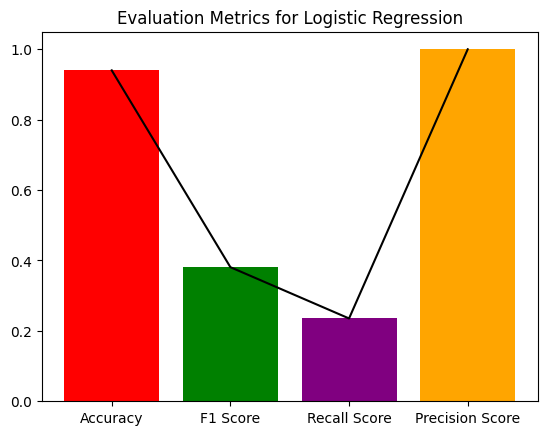

In [42]:


plt.bar(['Accuracy','F1 Score','Recall Score','Precision Score'],[ma_lr,f1_lr,recall_lr,precision_lr],color=['red','green','purple','orange'])
plt.plot([ma_lr,f1_lr,recall_lr,precision_lr],color='black')
plt.title('Evaluation Metrics for Logistic Regression')

Decision Tree Classifier

In [37]:
from sklearn.tree import DecisionTreeClassifier as dtc
classifier = dtc(max_depth=2)
classifier.fit(X_train,np.array(y_train).reshape(y_train.shape[0],1))

DecisionTreeClassifier(max_depth=2)

Evaluation the model

In [38]:
pred = np.array(classifier.predict(X_test))

recall_dtc = rs(y_test,pred)
precision_dtc = ps(y_test,pred)
f1_dtc = fs(y_test,pred)
ma_dtc = classifier.score(X_test,y_test)

In [39]:
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall_dtc)
print('Precision Score: ',precision_dtc)
print('F1 Score: ',f1_dtc)
print('Accuracy: ',ma_dtc)
a = pd.DataFrame(y_test)
a['pred']= classifier.predict(X_test)
print('\n\tTable 3\n')
print(a.head())

*** Evaluation metrics for test dataset ***

Recall Score:  0.7058823529411765
Precision Score:  1.0
F1 Score:  0.8275862068965517
Accuracy:  0.9769585253456221

	Table 3

      death  pred
427       0     0
552       0     0
735       0     0
592       0     0
1056      0     0


Text(0.5, 1.0, 'Evaluation Metrics for Decision Tree')

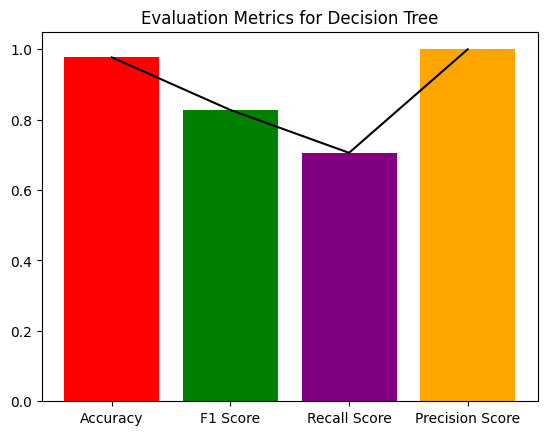

In [40]:
plt.bar(['Accuracy','F1 Score','Recall Score','Precision Score'],[ma_dtc,f1_dtc,recall_dtc,precision_dtc],color=['red','green','purple','orange'])
plt.plot([ma_dtc,f1_dtc,recall_dtc,precision_dtc],color='black')
plt.title('Evaluation Metrics for Decision Tree')

Visualizing the decision trees from random forest

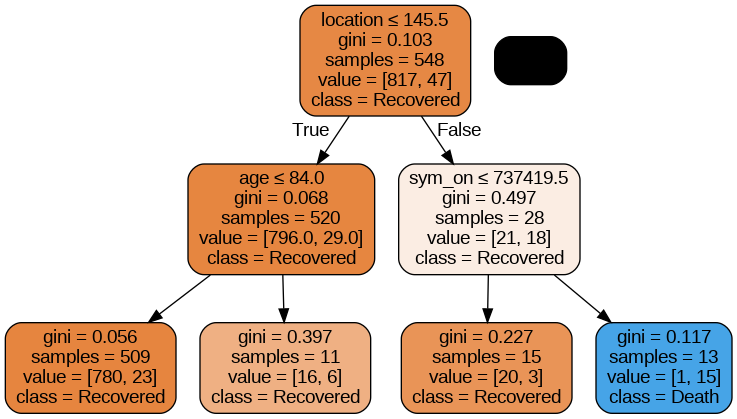

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO

# Train a RandomForestClassifier separately
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=10)
rf.fit(X_train, y_train)

# Extract one tree from the Random Forest
estimator = rf.estimators_[0]  # Get the first tree in the random forest

# Generate the graph
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_train.columns,  # Adjust feature names as needed
                class_names=['Recovered', 'Death'])  # Adjust class names as needed
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Display the image
Image(graph.create_png(), width=550, height=400)



In [47]:
from sklearn import svm
classifier = svm.SVC()
classifier.fit(X_train,np.array(y_train).reshape(y_train.shape[0],1))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

Evaluation the model

In [48]:
pred = np.array(classifier.predict(X_test))

recall_svm = rs(y_test,pred)
precision_svm = ps(y_test,pred)
f1_svm = fs(y_test,pred)
ma_svm = classifier.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall_svm)
print('Precision Score: ',precision_svm)
print('F1 Score: ',f1_svm)
print('Accuracy: ',ma_svm)
a = pd.DataFrame(y_test)
a['pred']= classifier.predict(X_test)
print('\n\tTable 3\n')
print(a.head())

*** Evaluation metrics for test dataset ***

Recall Score:  0.0
Precision Score:  0.0
F1 Score:  0.0
Accuracy:  0.9216589861751152

	Table 3

      death  pred
427       0     0
552       0     0
735       0     0
592       0     0
1056      0     0


Text(0.5, 1.0, 'Evaluation Metrics for Support Vector Machine')

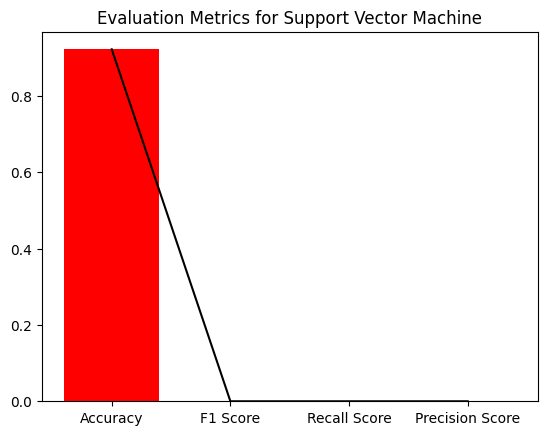

In [50]:
plt.bar(['Accuracy','F1 Score','Recall Score','Precision Score'],[ma_svm,f1_svm,recall_svm,precision_svm],color=['red','green','purple','orange'])
plt.plot([ma_svm,f1_svm,recall_svm,precision_svm],color='black')
plt.title('Evaluation Metrics for Support Vector Machine')

Gaussian Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,np.array(y_train).reshape(y_train.shape[0],1))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [52]:

pred = np.array(classifier.predict(X_test))

recall_gnb = rs(y_test,pred)
precision_gnb = ps(y_test,pred)
f1_gnb = fs(y_test,pred)
ma_gnb = classifier.score(X_test,y_test)

In [53]:
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall_gnb)
print('Precision Score: ',precision_gnb)
print('F1 Score: ',f1_gnb)
print('Accuracy: ',ma_gnb)
a = pd.DataFrame(y_test)
a['pred']= classifier.predict(X_test)
print('\n\tTable 3\n')
print(a.head())

*** Evaluation metrics for test dataset ***

Recall Score:  1.0
Precision Score:  0.1259259259259259
F1 Score:  0.2236842105263158
Accuracy:  0.45622119815668205

	Table 3

      death  pred
427       0     0
552       0     0
735       0     0
592       0     1
1056      0     1


Text(0.5, 1.0, 'Evaluation Metrics for Gaussian Naive Bayes')

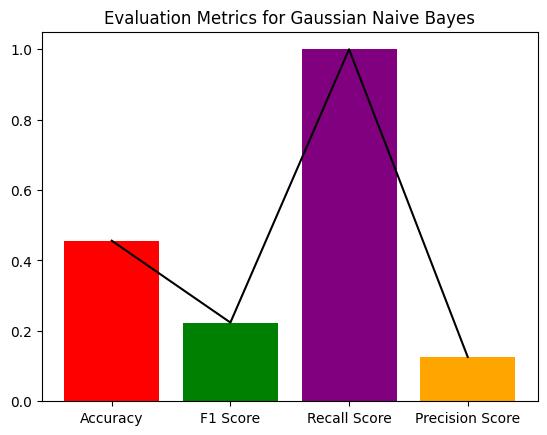

In [54]:
plt.bar(['Accuracy','F1 Score','Recall Score','Precision Score'],[ma_gnb,f1_gnb,recall_gnb,precision_gnb],color=['red','green','purple','orange'])
plt.plot([ma_gnb,f1_gnb,recall_gnb,precision_gnb],color='black')
plt.title('Evaluation Metrics for Gaussian Naive Bayes')


Boosted Random Forest

In [55]:
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import confusion_matrix as cm

Comparison of Evaluation Metrics

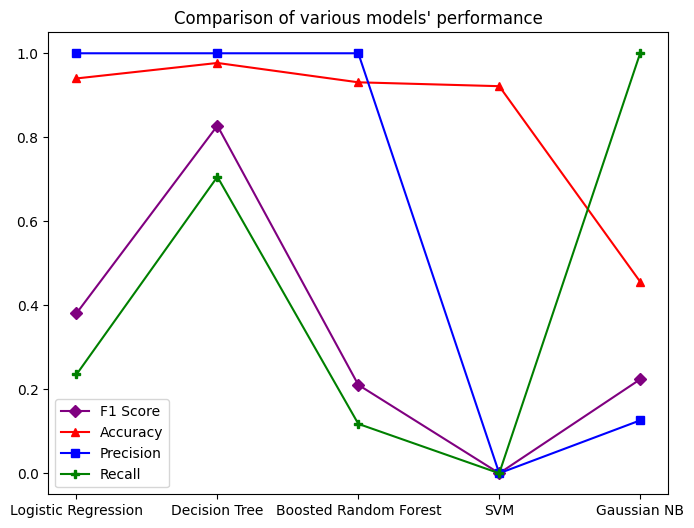

In [57]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
#plt.bar(['Logistic Regression','Decision Tree','SVM','Gaussian NB','Boosted Random Forest'],[f1_lr,f1_dtc,f1_svm,f1_gnb,f1],color=['red','green','purple','orange','Blue'])
plt.plot(['Logistic Regression','Decision Tree','Boosted Random Forest','SVM','Gaussian NB'],[f1_lr,f1_dtc,f1,f1_svm,f1_gnb],color='purple',marker='D')
plt.plot(['Logistic Regression','Decision Tree','Boosted Random Forest','SVM','Gaussian NB'],[ma_lr,ma_dtc,ma,ma_svm,ma_gnb],color='red',marker='^')
plt.plot(['Logistic Regression','Decision Tree','Boosted Random Forest','SVM','Gaussian NB'],[precision_lr,precision_dtc,precision,precision_svm,precision_gnb],color='blue',marker='s')
plt.plot(['Logistic Regression','Decision Tree','Boosted Random Forest','SVM','Gaussian NB'],[recall_lr,recall_dtc,recall,recall_svm,recall_gnb],color='green',marker='P')
plt.legend(('F1 Score','Accuracy','Precision','Recall'))
plt.title('Comparison of various models\' performance')

plt.show(fig)

In [58]:
#save the model
import pickle
filename = 'finalized_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [62]:
from google.colab import files

# Save the notebook as an HTML file
!jupyter nbconvert --to html /content/{CLR204LastNameFirstNameBrief}.html




[NbConvertApp] WARNING | pattern '/content/{CLR204LastNameFirstNameBrief}.html' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.ans